Version 8 Specifics:  

- Selected Base Stations: C, D, H, I
- Feature Engineering: time of day(bedtime, evening)
- Added lag features: 'nummsg3', 'erabaddatt', 'rlculbyte', 'bler_dl', 'attpaging', 'dltransmittedmcsavg'
- lag num: 1
- fillna with the mean of each feature
- StandardScaler (all stations as a whole)
- Drop['rachpreamblea', 'time_of_day_day', 'endcaddsucc', 'erabaddsucc', 'endcmodbymenbsucc', 'connestabsucc', 
       'handoversucc', 'endcmodbysgnbsucc', 'reestabsucc']
- Train Split = 8:1:1, No shuffle
- Models: xgb, lgbm
- Hyper parameter tuned

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing/postprocessing
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance as xgb_plot_importance 
from lightgbm import plot_importance as lgbm_plot_importance
import optuna

# ML Models (Regression)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor

# Regression Evaluation Measures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Save the model
import joblib

%matplotlib inline

In [5]:
def display_rows_cols(row=None, col=None):  
    pd.set_option('display.max_rows', row)  # Adjust limit. Default = 20
    pd.set_option('display.max_columns', col)  # Adjust limit. Default = 20
    print(f"Num rows displayed limit: {pd.get_option('display.max_rows')}")
    print(f"Num columns displayed limit: {pd.get_option('display.max_columns')}")

display_rows_cols(row=40)

Num rows displayed limit: 40
Num columns displayed limit: None


In [6]:
Q1_train = pd.read_csv('../Q1_data/Q1_train.csv')
print(Q1_train.shape)
Q1_train.head(2)

(137445, 39)


,datetime,ru_id,scgfail,scgfailratio,erabaddatt,erabaddsucc,endcaddatt,endcaddsucc,endcmodbymenbatt,endcmodbymenbsucc,endcmodbysgnbatt,endcmodbysgnbsucc,connestabatt,connestabsucc,redirectiontolte_coverageout,redirectiontolte_epsfallback,redirectiontolte_emergencyfallback,handoveratt,handoversucc,reestabatt,reestabsucc,rlculbyte,rlcdlbyte,totprbulavg,totprbdlavg,dlreceivedriavg,dltransmittedmcsavg,airmaculbyte,airmacdlbyte,bler_ul,bler_dl,rachpreamblea,numrar,nummsg3,attpaging,rssipathavg,dlreceivedcqiavg,endcrelbymenb,uenomax
0,2023-05-19 00:00:00,BaseStationG,0,0.0,12,12,10,10,0,0,0,0,4,4,0,0,0,0,0,0,0,0.0,0.0,0.0,0.8,2.4,0.8,36.0,34.0,10.5,22.4,47.0,47.0,17.0,2243.0,-93.3,11.1,0,1
1,2023-05-19 00:00:00,BaseStationE,0,0.0,28,28,27,27,11,11,34,33,1,1,0,0,0,0,0,0,0,1242.0,57165.0,0.2,1.3,2.1,8.2,1915.0,73315.0,19.4,8.8,174.0,174.0,39.0,2240.0,-93.5,10.2,4,5


# Data Preprocessing

### 1. Missing Values

In [7]:
def show_null_pct(df):
    '''
    Show null count & percentage
    '''
    null_count_df = pd.DataFrame(df.isna().sum().sort_values(ascending=False))
    null_count_df.rename({0: 'Null Counts'}, axis=1, inplace=True)
    null_count_df['Null Ratio per Feature'] = np.round((null_count_df['Null Counts'] / len(df)) * 100, 4)
    null_count_df = null_count_df[null_count_df['Null Counts'] > 0]
    return null_count_df

print("Number of Columns that contain NaNs: ", show_null_pct(Q1_train).shape[0])
show_null_pct(Q1_train)

Number of Columns that contain NaNs:  16


,Null Counts,Null Ratio per Feature
bler_dl,9,0.0065
bler_ul,9,0.0065
rlcdlbyte,9,0.0065
totprbulavg,9,0.0065
totprbdlavg,9,0.0065
dlreceivedriavg,9,0.0065
dltransmittedmcsavg,9,0.0065
airmaculbyte,9,0.0065
airmacdlbyte,9,0.0065
rlculbyte,9,0.0065


In [8]:
Q1_train['time'] = pd.to_datetime(Q1_train['datetime']).dt.time  ## Add a new col that contains 'time'
train = Q1_train.sort_values(by=['time', 'ru_id'])  ## Sort by 'time' and 'ru_id'
grouped_means = train.drop('datetime', axis=1).groupby(['time', 'ru_id']).transform('mean')
train_filled = train.copy()  
train_filled[train_filled.columns.difference(['datetime'])] = train[train.columns.difference(['datetime'])].fillna(grouped_means)
train_wo_nan = train_filled.sort_values(by=['datetime', 'ru_id'])
train_wo_nan.drop('time', axis=1, inplace=True)
train_wo_nan.head(2)

,datetime,ru_id,scgfail,scgfailratio,erabaddatt,erabaddsucc,endcaddatt,endcaddsucc,endcmodbymenbatt,endcmodbymenbsucc,endcmodbysgnbatt,endcmodbysgnbsucc,connestabatt,connestabsucc,redirectiontolte_coverageout,redirectiontolte_epsfallback,redirectiontolte_emergencyfallback,handoveratt,handoversucc,reestabatt,reestabsucc,rlculbyte,rlcdlbyte,totprbulavg,totprbdlavg,dlreceivedriavg,dltransmittedmcsavg,airmaculbyte,airmacdlbyte,bler_ul,bler_dl,rachpreamblea,numrar,nummsg3,attpaging,rssipathavg,dlreceivedcqiavg,endcrelbymenb,uenomax
6,2023-05-19 00:00:00,BaseStationA,0,0.0,9,9,5,5,2,2,7,7,1,1,1,0,0,0,0,0,0,48.0,244.0,0.0,0.8,1.4,3.5,203.0,306.0,23.6,6.4,17.0,17.0,11.0,2083.0,-92.8,11.2,3,1
5,2023-05-19 00:00:00,BaseStationC,0,0.0,13,13,9,9,7,7,18,18,10,10,0,0,0,0,0,0,0,959.0,53771.0,0.2,1.4,2.0,6.5,2006.0,55524.0,15.7,16.6,47.0,47.0,25.0,2083.0,-91.7,9.4,9,4


### 2. Outliers

In [9]:
stations_to_include = ['BaseStationC', 'BaseStationD', 'BaseStationH', 'BaseStationI']
train_df = train_wo_nan[train_wo_nan['ru_id'].isin(stations_to_include)]

train_df.head(5)

,datetime,ru_id,scgfail,scgfailratio,erabaddatt,erabaddsucc,endcaddatt,endcaddsucc,endcmodbymenbatt,endcmodbymenbsucc,endcmodbysgnbatt,endcmodbysgnbsucc,connestabatt,connestabsucc,redirectiontolte_coverageout,redirectiontolte_epsfallback,redirectiontolte_emergencyfallback,handoveratt,handoversucc,reestabatt,reestabsucc,rlculbyte,rlcdlbyte,totprbulavg,totprbdlavg,dlreceivedriavg,dltransmittedmcsavg,airmaculbyte,airmacdlbyte,bler_ul,bler_dl,rachpreamblea,numrar,nummsg3,attpaging,rssipathavg,dlreceivedcqiavg,endcrelbymenb,uenomax
5,2023-05-19 00:00:00,BaseStationC,0,0.0,13,13,9,9,7,7,18,18,10,10,0,0,0,0,0,0,0,959.0,53771.0,0.2,1.4,2.0,6.5,2006.0,55524.0,15.7,16.6,47.0,47.0,25.0,2083.0,-91.7,9.4,9,4
4,2023-05-19 00:00:00,BaseStationD,0,0.0,29,29,29,29,1,1,18,18,1,1,0,0,0,1,1,0,0,492.0,85493.0,0.1,1.2,2.0,11.3,853.0,87264.0,18.3,9.2,51.0,51.0,35.0,2083.0,-92.7,12.4,28,4
7,2023-05-19 00:00:00,BaseStationH,0,0.0,10,10,9,9,0,0,1,1,7,7,0,0,0,1,1,0,0,0.0,0.0,0.0,0.8,2.4,6.4,292.0,1944.0,13.6,16.9,25.0,25.0,18.0,1574.0,-92.0,12.1,10,1
3,2023-05-19 00:00:00,BaseStationI,0,0.0,1,1,1,1,0,0,0,0,3,3,0,0,0,0,0,0,0,10.0,26.0,0.0,0.8,1.4,3.1,32.0,36.0,8.5,5.7,259.0,259.0,5.0,1401.0,-92.8,13.6,0,1
13,2023-05-19 00:05:00,BaseStationC,1,7.7,13,13,12,12,3,3,11,11,5,5,0,0,0,0,0,0,0,271.0,38283.0,0.1,1.2,2.0,8.5,845.0,40370.0,16.3,10.8,37.0,37.0,18.0,1936.0,-91.7,9.1,7,3


### 3. Data Formatting

In [10]:
# Rearrange the target
target = train_df.pop('uenomax')
train_df.insert(0, target.name, target)

In [11]:
# Set 'datetime' as datetime data type
train_df['datetime'] = pd.to_datetime(train_df['datetime'], format='%Y-%m-%d %H:%M:%S')

### 4. Feature Engineering

In [12]:
# Extract relevant features from datetime
def categorize_hour(hour):
    '''
    'bedtime' = 00:05 - 07:00  
    'daytime' = 07:05 - 17:00  
    'evening' = 17:05 - 00:00  
    '''
    if 0 <= hour < 7:
        return 'bedtime'
    elif 7 <= hour < 17:
        return 'day'
    else:
        return 'evening'
    
# Create daytime/evening/bedtime
train_df['hour'] = train_df['datetime'].dt.hour
train_df['time_of_day'] = train_df['hour'].apply(categorize_hour)

# Drop redundant cols
train_df.set_index('datetime', inplace=True)
train_df = train_df.drop(['hour'], axis=1)

train_df.head()

,uenomax,ru_id,scgfail,scgfailratio,erabaddatt,erabaddsucc,endcaddatt,endcaddsucc,endcmodbymenbatt,endcmodbymenbsucc,endcmodbysgnbatt,endcmodbysgnbsucc,connestabatt,connestabsucc,redirectiontolte_coverageout,redirectiontolte_epsfallback,redirectiontolte_emergencyfallback,handoveratt,handoversucc,reestabatt,reestabsucc,rlculbyte,rlcdlbyte,totprbulavg,totprbdlavg,dlreceivedriavg,dltransmittedmcsavg,airmaculbyte,airmacdlbyte,bler_ul,bler_dl,rachpreamblea,numrar,nummsg3,attpaging,rssipathavg,dlreceivedcqiavg,endcrelbymenb,time_of_day
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-19 00:00:00,4,BaseStationC,0,0.0,13,13,9,9,7,7,18,18,10,10,0,0,0,0,0,0,0,959.0,53771.0,0.2,1.4,2.0,6.5,2006.0,55524.0,15.7,16.6,47.0,47.0,25.0,2083.0,-91.7,9.4,9,bedtime
2023-05-19 00:00:00,4,BaseStationD,0,0.0,29,29,29,29,1,1,18,18,1,1,0,0,0,1,1,0,0,492.0,85493.0,0.1,1.2,2.0,11.3,853.0,87264.0,18.3,9.2,51.0,51.0,35.0,2083.0,-92.7,12.4,28,bedtime
2023-05-19 00:00:00,1,BaseStationH,0,0.0,10,10,9,9,0,0,1,1,7,7,0,0,0,1,1,0,0,0.0,0.0,0.0,0.8,2.4,6.4,292.0,1944.0,13.6,16.9,25.0,25.0,18.0,1574.0,-92.0,12.1,10,bedtime
2023-05-19 00:00:00,1,BaseStationI,0,0.0,1,1,1,1,0,0,0,0,3,3,0,0,0,0,0,0,0,10.0,26.0,0.0,0.8,1.4,3.1,32.0,36.0,8.5,5.7,259.0,259.0,5.0,1401.0,-92.8,13.6,0,bedtime
2023-05-19 00:05:00,3,BaseStationC,1,7.7,13,13,12,12,3,3,11,11,5,5,0,0,0,0,0,0,0,271.0,38283.0,0.1,1.2,2.0,8.5,845.0,40370.0,16.3,10.8,37.0,37.0,18.0,1936.0,-91.7,9.1,7,bedtime


In [13]:
# Convert categorical variables
train_df2 = pd.get_dummies(train_df, columns=['time_of_day'])
train_df2.head(2)

,uenomax,ru_id,scgfail,scgfailratio,erabaddatt,erabaddsucc,endcaddatt,endcaddsucc,endcmodbymenbatt,endcmodbymenbsucc,endcmodbysgnbatt,endcmodbysgnbsucc,connestabatt,connestabsucc,redirectiontolte_coverageout,redirectiontolte_epsfallback,redirectiontolte_emergencyfallback,handoveratt,handoversucc,reestabatt,reestabsucc,rlculbyte,rlcdlbyte,totprbulavg,totprbdlavg,dlreceivedriavg,dltransmittedmcsavg,airmaculbyte,airmacdlbyte,bler_ul,bler_dl,rachpreamblea,numrar,nummsg3,attpaging,rssipathavg,dlreceivedcqiavg,endcrelbymenb,time_of_day_bedtime,time_of_day_day,time_of_day_evening
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-19,4,BaseStationC,0,0.0,13,13,9,9,7,7,18,18,10,10,0,0,0,0,0,0,0,959.0,53771.0,0.2,1.4,2.0,6.5,2006.0,55524.0,15.7,16.6,47.0,47.0,25.0,2083.0,-91.7,9.4,9,True,False,False
2023-05-19,4,BaseStationD,0,0.0,29,29,29,29,1,1,18,18,1,1,0,0,0,1,1,0,0,492.0,85493.0,0.1,1.2,2.0,11.3,853.0,87264.0,18.3,9.2,51.0,51.0,35.0,2083.0,-92.7,12.4,28,True,False,False


In [17]:
# Create lag features
lag_var_list = ['nummsg3', 'erabaddatt', 'rlculbyte', 'bler_dl', 'attpaging', 'dltransmittedmcsavg']

def create_lag(df, var_list, num_stations, num_lag):
    df['hour'] = df.index.hour  # datetime 인덱스에서 시간 추출

    for lag in range(0, num_lag):
        for var in var_list:
            df[f'{var}_lag{lag+1}'] = df.groupby('ru_id')[var].shift(1)
            df[f'{var}_lag{lag+1}'] = df.groupby(['ru_id', 'hour'])[f'{var}_lag{lag+1}'].transform(lambda x: x.fillna(x.mean()))
    
    df.drop('hour', axis=1, inplace=True)
    return df

train_df3 = create_lag(train_df2, lag_var_list, num_stations=4, num_lag=1)


In [18]:
# Drop columns
drop_cols = ['rachpreamblea', 'time_of_day_day', 'endcaddsucc', 'erabaddsucc', 'endcmodbymenbsucc', 'connestabsucc', 'handoversucc', 'endcmodbysgnbsucc', 'reestabsucc']
train_df4 = train_df3.drop(drop_cols, axis=1)

In [19]:
train_df4.head(5)

,uenomax,ru_id,scgfail,scgfailratio,erabaddatt,endcaddatt,endcmodbymenbatt,endcmodbysgnbatt,connestabatt,redirectiontolte_coverageout,redirectiontolte_epsfallback,redirectiontolte_emergencyfallback,handoveratt,reestabatt,rlculbyte,rlcdlbyte,totprbulavg,totprbdlavg,dlreceivedriavg,dltransmittedmcsavg,airmaculbyte,airmacdlbyte,bler_ul,bler_dl,numrar,nummsg3,attpaging,rssipathavg,dlreceivedcqiavg,endcrelbymenb,time_of_day_bedtime,time_of_day_evening,nummsg3_lag1,erabaddatt_lag1,rlculbyte_lag1,bler_dl_lag1,attpaging_lag1,dltransmittedmcsavg_lag1
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-19 00:00:00,4,BaseStationC,0,0.0,13,9,7,18,10,0,0,0,0,0,959.0,53771.0,0.2,1.4,2.0,6.5,2006.0,55524.0,15.7,16.6,47.0,25.0,2083.0,-91.7,9.4,9,True,False,37.223922,28.731572,1716.778860,10.861613,1938.233658,8.815716
2023-05-19 00:00:00,4,BaseStationD,0,0.0,29,29,1,18,1,0,0,0,1,0,492.0,85493.0,0.1,1.2,2.0,11.3,853.0,87264.0,18.3,9.2,51.0,35.0,2083.0,-92.7,12.4,28,True,False,26.194715,21.247566,1118.201669,12.473853,1938.233658,7.938804
2023-05-19 00:00:00,1,BaseStationH,0,0.0,10,9,0,1,7,0,0,0,1,0,0.0,0.0,0.0,0.8,2.4,6.4,292.0,1944.0,13.6,16.9,25.0,18.0,1574.0,-92.0,12.1,10,True,False,14.308762,8.235049,617.915160,7.771627,1917.812239,5.711544
2023-05-19 00:00:00,1,BaseStationI,0,0.0,1,1,0,0,3,0,0,0,0,0,10.0,26.0,0.0,0.8,1.4,3.1,32.0,36.0,8.5,5.7,259.0,5.0,1401.0,-92.8,13.6,0,True,False,9.639777,6.646732,403.966620,10.616968,1032.916551,4.720167
2023-05-19 00:05:00,3,BaseStationC,1,7.7,13,12,3,11,5,0,0,0,0,0,271.0,38283.0,0.1,1.2,2.0,8.5,845.0,40370.0,16.3,10.8,37.0,18.0,1936.0,-91.7,9.1,7,True,False,25.000000,13.000000,959.000000,16.600000,2083.000000,6.500000


# Model Training #1 (80% trainset)

In [20]:
def ts_train_test_split(df):
    # Set X = features, y = label
    X_features = df.drop(['uenomax', 'ru_id'], axis=1)
    y_label = df['uenomax']

    # Train/Validation Split
    train_size = int(0.8 * len(X_features))
    val_size = int(0.1 * len(X_features))
    # test_size = int(0.1 * len(X_features))

    X_train = X_features[:train_size]
    X_val = X_features[train_size : train_size + val_size]
    X_test = X_features[train_size + val_size:]

    y_train = y_label[:train_size]
    y_val = y_label[train_size : train_size + val_size]
    y_test = y_label[train_size + val_size:]

    print('Train, Validation, Test Size:', X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Execute
X_train, X_val, X_test, y_train, y_val, y_test = ts_train_test_split(train_df4)

Train, Validation, Test Size: (54979, 36) (6872, 36) (6873, 36) (54979,) (6872,) (6873,)


### Feature Scaling

In [21]:
scaler = StandardScaler()

feature_cols = [col for col in X_train.columns if col not in ['uenomax', 'ru_id', 'time_of_day_bedtime', 'time_of_day_evening']]
print(feature_cols)

['scgfail', 'scgfailratio', 'erabaddatt', 'endcaddatt', 'endcmodbymenbatt', 'endcmodbysgnbatt', 'connestabatt', 'redirectiontolte_coverageout', 'redirectiontolte_epsfallback', 'redirectiontolte_emergencyfallback', 'handoveratt', 'reestabatt', 'rlculbyte', 'rlcdlbyte', 'totprbulavg', 'totprbdlavg', 'dlreceivedriavg', 'dltransmittedmcsavg', 'airmaculbyte', 'airmacdlbyte', 'bler_ul', 'bler_dl', 'numrar', 'nummsg3', 'attpaging', 'rssipathavg', 'dlreceivedcqiavg', 'endcrelbymenb', 'nummsg3_lag1', 'erabaddatt_lag1', 'rlculbyte_lag1', 'bler_dl_lag1', 'attpaging_lag1', 'dltransmittedmcsavg_lag1']


In [22]:
def scale_fit_transform(df):
    # Scaler fit and transform
    scaler.fit(df[feature_cols])  # Fit
    scaled_features = scaler.transform(df[feature_cols])  # Transform

    # Create a dataframe for the scaled features
    scaled_X = pd.DataFrame(scaled_features, columns=feature_cols)

    # Part A and Part B (OHE)
    part_a_reset = df[['time_of_day_bedtime', 'time_of_day_evening']].reset_index(drop=False)
    part_b_reset = scaled_X.reset_index(drop=True)

    # Concat Part A and Part B
    scaled_df = pd.concat([part_a_reset, part_b_reset], axis=1)
    scaled_df.set_index('datetime', inplace=True)

    return scaled_df

def scale_transform(df):
    # Transform
    scaled_features = scaler.transform(df[feature_cols])  # Transform

    # Create a dataframe for the scaled features
    scaled_X = pd.DataFrame(scaled_features, columns=feature_cols)

    # Part A and Part B (OHE)
    part_a_reset = df[['time_of_day_bedtime', 'time_of_day_evening']].reset_index(drop=False)
    part_b_reset = scaled_X.reset_index(drop=True)

    # Concat Part A and Part B
    scaled_df = pd.concat([part_a_reset, part_b_reset], axis=1)
    scaled_df.set_index('datetime', inplace=True)

    return scaled_df

scaled_X_train = scale_fit_transform(X_train)
scaled_X_val = scale_transform(X_val)
scaled_X_test = scale_transform(X_test)

In [23]:
start_time = time.time()
def model_training(num_folds):
    trained_models = {}
    xgb = XGBRegressor(n_estimators=200, learning_rate=0.04, max_depth=8, min_child_weight=6, subsample=0.9, colsample_bytree=0.7, booster='gbtree', reg_alpha=0.8, reg_lambda=0.5, gamma=0.1, n_jobs=-1, random_state=48)
    lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.2, max_depth=5, min_child_samples=20, subsample=0.8, colsample_bytree=0.6, boosting_type='dart', n_jobs=-1, random_state=48)

    models = [xgb, lgbm]
    model_names = ['XGBoost', 'LightGBM']

    kfold = num_folds
    print('Train Set MAE')
    for model, model_name in zip(models, model_names):
        # Training Set
        scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
        train_maes = -scores
        mean_mae = train_maes.mean()
        print(f"{model_name}\tMean of {kfold}-fold Cross-Validation MAE = \t{mean_mae:.4f}")

        # Fit the model on the train set and save it
        each_model = model.fit(X_train, y_train)
        trained_models[model_name] = each_model

    print('\n')
    for model, model_name in zip(models, model_names):
        # Validation Set
        y_val_pred = np.round(model.predict(X_val)).astype(int)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        print(f"{model_name} Validation MAE: {val_mae}")

    print('\n')
    for model, model_name in zip(models, model_names):
        # Test Set
        y_test_pred = np.round(model.predict(X_test)).astype(int)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        print(f"{model_name} Testset MAE: {test_mae}")
        
    return trained_models

# Execute
trained_models = model_training(num_folds=3)

end_time = time.time()
execution_time = end_time - start_time
print("\n", f"Execution time:{execution_time: .2f} seconds")

Train Set MAE
XGBoost	Mean of 3-fold Cross-Validation MAE = 	0.5123
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4370
[LightGBM] [Info] Number of data points in the train set: 36652, number of used features: 35
[LightGBM] [Info] Start training from score 2.723780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [24]:
# Create a Voting Model
start_time = time.time()
models = [('XGBoost', trained_models['XGBoost']),
          ('LightGBM', trained_models['LightGBM'])]

# Create a VotingRegressor ensemble
voting_ensemble = VotingRegressor(estimators=models)

# Fit the ensemble on the training data
voting_ensemble.fit(scaled_X_train, y_train)

# Make predictions on Validation Set
y_val_pred = np.round(voting_ensemble.predict(scaled_X_val)).astype(int)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation MAE: {val_mae}")

# Make predictions on Test Set
y_test_pred = np.round(voting_ensemble.predict(scaled_X_test)).astype(int)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Testset MAE: {test_mae}")

end_time = time.time()
execution_time = end_time - start_time
print("\n",f"Execution time:{execution_time: .2f} seconds")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4678
[LightGBM] [Info] Number of data points in the train set: 54979, number of used features: 35
[LightGBM] [Info] Start training from score 2.675149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

### Feature Importance

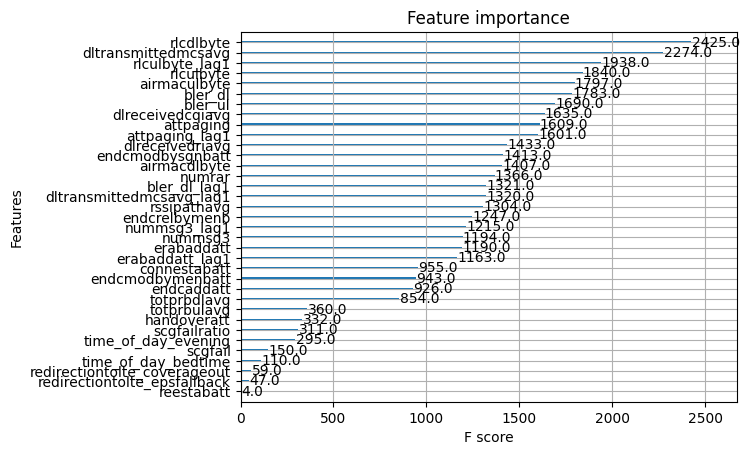

In [25]:
xgb_plot_importance(trained_models['XGBoost'])
plt.show()

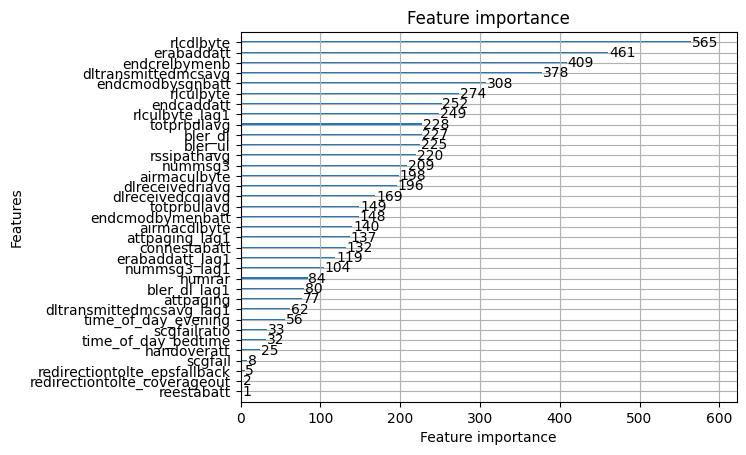

In [26]:
lgbm_plot_importance(trained_models['LightGBM'])
plt.show()

# Model Training #2 (100% trainset)

In [27]:
# Trainset size = 100% of Q1_train.csv
X_train_full = train_df4.drop(['uenomax', 'ru_id'], axis=1)
y_train_full = train_df4['uenomax']

scaler = StandardScaler()
scaled_X_train_full = scale_fit_transform(X_train_full)

In [28]:
# XGB HyperParm Tuning

def xgb_hyperparam_tuning(n_trials):
    start_time = time.time()

    def xgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 250),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 1.0)
        }

        xgb_model = XGBRegressor(n_jobs=-1, random_state=48, **params)
        scores = cross_val_score(xgb_model, scaled_X_train_full, y_train_full, cv=3, scoring='neg_mean_absolute_error')
        return -scores.mean() 

    # Perform Bayesian optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(xgb_objective, n_trials)

    # Get the best parameters and score
    best_params = study.best_params
    best_score = study.best_value

    print("Best Parameters:", best_params)
    print("Best MAE:", best_score)

    best_xgb_model = XGBRegressor(random_state=48, **best_params)
    best_xgb_model.fit(scaled_X_train_full, y_train_full)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time:{execution_time: .2f} seconds")
    
    return best_xgb_model

# Execute
best_xgb_model = xgb_hyperparam_tuning(n_trials=100)

[I 2023-08-24 18:07:40,966] A new study created in memory with name: no-name-7ccce70e-d168-4e20-b3df-49d50c4de06e
[I 2023-08-24 18:07:57,047] Trial 0 finished with value: 0.5283730776410158 and parameters: {'n_estimators': 104, 'learning_rate': 0.16962694402905157, 'max_depth': 7, 'min_child_weight': 1.1045927525234875, 'subsample': 0.7039191538385032, 'colsample_bytree': 0.8321554224281014, 'booster': 'dart', 'reg_alpha': 0.03233314303477397, 'reg_lambda': 0.340024265203985, 'gamma': 0.11750037347377373}. Best is trial 0 with value: 0.5283730776410158.


Best Parameters: {'n_estimators': 104, 'learning_rate': 0.16962694402905157, 'max_depth': 7, 'min_child_weight': 1.1045927525234875, 'subsample': 0.7039191538385032, 'colsample_bytree': 0.8321554224281014, 'booster': 'dart', 'reg_alpha': 0.03233314303477397, 'reg_lambda': 0.340024265203985, 'gamma': 0.11750037347377373}
Best MAE: 0.5283730776410158
Execution time: 23.67 seconds


In [29]:
# LGBM HyperParm Tuning

def lgbm_hyperparam_tuning(n_trials):
    start_time = time.time()

    def lgbm_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 250),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.35),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        }

        lgbm_model = LGBMRegressor(n_jobs=-1, random_state=48, **params)
        scores = cross_val_score(lgbm_model, scaled_X_train_full, y_train_full, cv=3, scoring='neg_mean_absolute_error')
        return -scores.mean()

    # Perform Bayesian optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(lgbm_objective, n_trials)

    # Get the best parameters and score
    best_params = study.best_params
    best_score = study.best_value

    print("Best Parameters:", best_params)
    print("Best MAE:", best_score)

    best_lgbm_model = LGBMRegressor(random_state=48, **best_params)
    best_lgbm_model.fit(scaled_X_train_full, y_train_full)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time:{execution_time: .2f} seconds")
    
    return best_lgbm_model

# Execute
best_lgbm_model = lgbm_hyperparam_tuning(n_trials=100)

[I 2023-08-24 18:08:04,657] A new study created in memory with name: no-name-37af442e-18a8-496c-bedd-81ad9f8fcfe4


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4494
[LightGBM] [Info] Number of data points in the train set: 45816, number of used features: 35
[LightGBM] [Info] Start training from score 2.799197
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4655
[LightGBM] [Info] Number of data points in the train set: 45816, number of used features: 35
[LightGBM] [Info] Start training from score 2.714488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4654
[LightGBM] [Info] Number of data points in the train set: 45816, number of used features: 35
[LightGBM] [Info] 

[I 2023-08-24 18:08:06,736] Trial 0 finished with value: 0.5639531768292249 and parameters: {'n_estimators': 226, 'learning_rate': 0.07215767263530756, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.8759819676790067, 'colsample_bytree': 0.9159632543286593, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.5639531768292249.


Best Parameters: {'n_estimators': 226, 'learning_rate': 0.07215767263530756, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.8759819676790067, 'colsample_bytree': 0.9159632543286593, 'boosting_type': 'dart'}
Best MAE: 0.5639531768292249
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4740
[LightGBM] [Info] Number of data points in the train set: 68724, number of used features: 35
[LightGBM] [Info] Start training from score 2.721073
Execution time: 3.32 seconds


In [30]:
# Create a new Voting Model
start_time = time.time()
best_models = [('XGBoost', best_xgb_model),
               ('LightGBM', best_lgbm_model)]

# Create a VotingRegressor ensemble
best_voting_ensemble = VotingRegressor(estimators=best_models)

# Fit the ensemble on the training data
best_voting_ensemble.fit(scaled_X_train_full, y_train_full)

end_time = time.time()
execution_time = end_time - start_time
print("\n",f"Execution time:{execution_time: .2f} seconds")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4740
[LightGBM] [Info] Number of data points in the train set: 68724, number of used features: 35
[LightGBM] [Info] Start training from score 2.721073

 Execution time: 10.08 seconds


### Save the scaler and the model

In [31]:
# Save the fitted scaler
filename_scaler = '../2_저장된모델/fitted_scaler.pkl'
joblib.dump(scaler, filename_scaler)
print("Scaler saved as", filename_scaler)

# Save the fitted model
filename_model = '../2_저장된모델/voting_ensemble.joblib'
joblib.dump(best_voting_ensemble, filename_model)
print("Model saved as", filename_model)

Scaler saved as ../2_저장된모델/fitted_scaler.pkl
Model saved as ../2_저장된모델/voting_ensemble.joblib
